# Challenge 3
## Natural Language Processing
### Feeling analysis on Amazon 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# nltk.download('stopwords')
# nltk.download('punkt')

RANDOM_SEED = 2_055

1) Initial data exploration

In [2]:
reviews = pd.read_csv("amazon_alexa.csv")
reviews

,rating,date,variation,verified_reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!
1,5,31-Jul-18,Charcoal Fabric,Loved it!
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer..."
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...
4,5,31-Jul-18,Charcoal Fabric,Music
...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe..."
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check..."
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my..."
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...


a) Existence of empty data.

In [3]:
reviews.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
dtype: int64

In [4]:
# Replace NaN with an empty string to avoid issues in future usage
reviews["verified_reviews"] = reviews["verified_reviews"].fillna("")

b) Customer ratings (*rating* column).

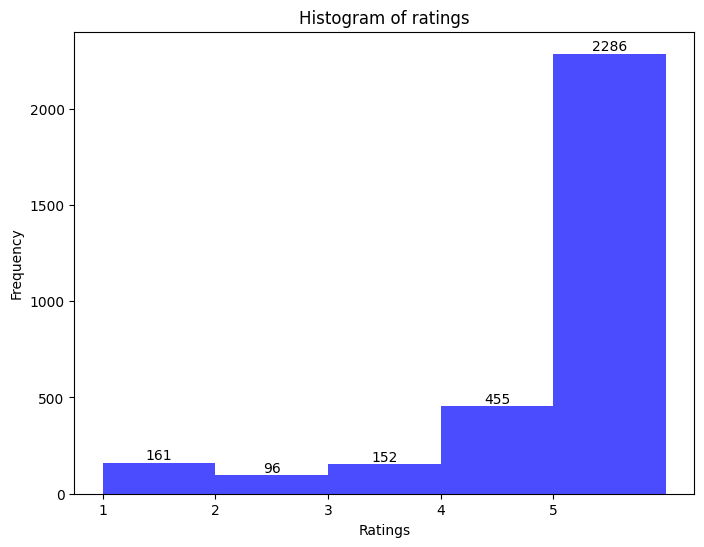

In [5]:
# Define the range and step for the bins
min_rating = reviews['rating'].min()
max_rating = reviews['rating'].max()
bins = range(min_rating, max_rating + 2, 1)  # +2 to include the last edge

# Create the histogram
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(reviews['rating'], bins=bins, color='blue', alpha=0.7)

# Add numbers above each bar
for rect, count in zip(patches, n):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2., height, f'{int(count)}', ha='center', va='bottom')

plt.title('Histogram of ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

# Set x-axis ticks
plt.xticks(range(min_rating, max_rating + 1, 1))

plt.show()

c) The length (number of words) of the opinions.

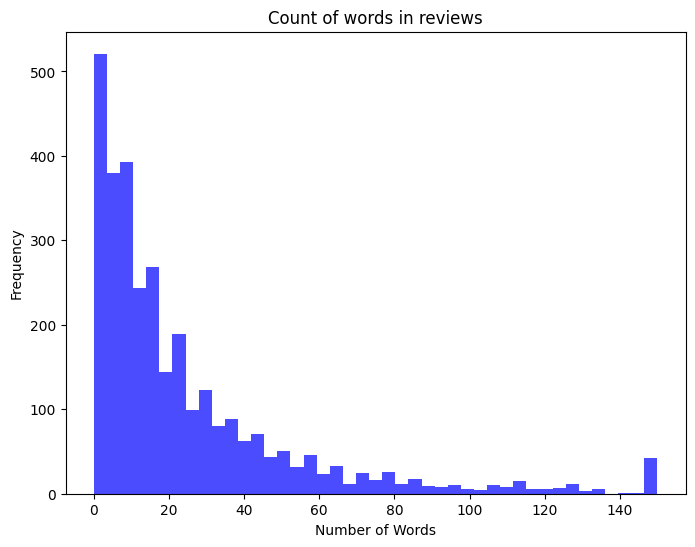

In [6]:
# Count words in a sentence
def word_count(sentence):
    return len(sentence.split())


# Apply the function to the review column
reviews['word_count'] = reviews['verified_reviews'].apply(word_count)
reviews['word_count'] = reviews['word_count'].clip(upper=150)  # Note: clip reviews with very high word count

# Create the histogram
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(reviews['word_count'], bins='auto', color='blue', alpha=0.7)

plt.title('Count of words in reviews')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.show()

d) A couple of opinions whose length is around the numerical average of words, taking as a reference the corpus of opinions

In [7]:
word_count_mean = floor(reviews['word_count'].mean())
average_length_reviews = reviews[reviews['word_count'] == word_count_mean]
sample = average_length_reviews.sample(2)

print("Sample of opinions with an average length:")
print(f"Opinion 1: {sample.iloc[0]['verified_reviews']}")
print(f"Opinion 2: {sample.iloc[1]['verified_reviews']}")

Sample of opinions with an average length:
Opinion 1: BEST father's day gift. Dad joked to my mom that Alexa will be the one listening to all of his (repeated) stories going forward.
Opinion 2: So far it has worked well. Not always intuitive as to how to link different devices, or "skills", but getting the hang of it.


e) Words with the greatest presence in the corpus of opinions.

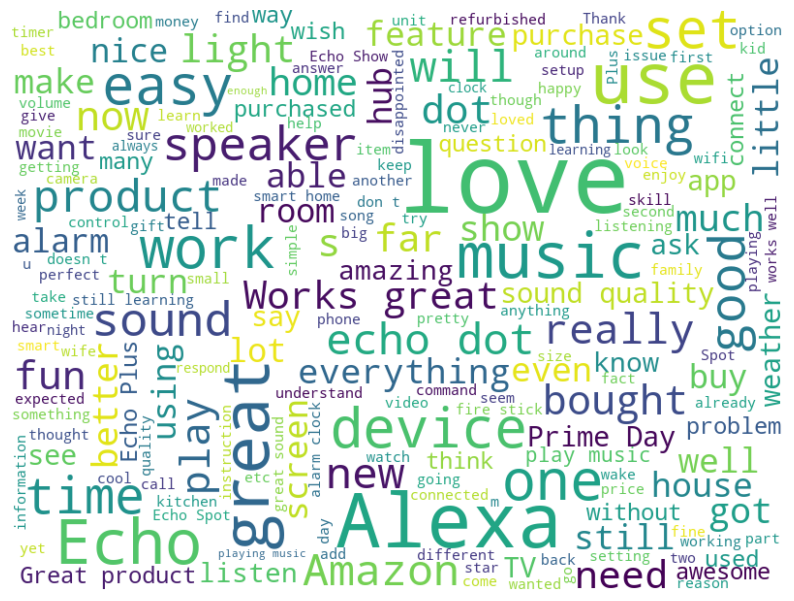

In [8]:
corpus = " ".join(sentence for sentence in reviews['verified_reviews'])

wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    max_font_size=100
).generate(corpus)

# Display the generated WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

2) Text preprocessing

In this phase it is necessary to preprocess the text with the opinions as previous step to the construction of the model. To do so, code a function to delete both punctuation marks and irrelevant words, so then it can be applied to the corresponding Pandas column. 

In [9]:
def remove_punctuation(sentence):
    return ''.join(char for char in sentence if char not in string.punctuation)

In [10]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)

In [11]:
def clean_sentence(sentence):
    return remove_stop_words(remove_punctuation(sentence))

In [12]:
reviews["verified_reviews"] = reviews["verified_reviews"].apply(clean_sentence)

In [13]:
reviews

,rating,date,variation,verified_reviews,word_count
0,5,31-Jul-18,Charcoal Fabric,Love Echo,3
1,5,31-Jul-18,Charcoal Fabric,Loved,2
2,4,31-Jul-18,Walnut Finish,Sometimes playing game answer question correct...,38
3,5,31-Jul-18,Charcoal Fabric,lot fun thing 4 yr old learns dinosaurs contro...,34
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,Perfect kids adults everyone,8
3146,5,30-Jul-18,Black Dot,Listening music searching locations checking t...,23
3147,5,30-Jul-18,Black Dot,love things running entire home TV lights ther...,83
3148,5,30-Jul-18,White Dot,complaint sound quality isnt great mostly use ...,76


3) previous step to model preparation

Add a column named "feedback" with values 1 (which means having a positive opinion) and 0 (which means having a negative opinion) from the ratings given by te Amazon clients. For this purpose, in order to reduce the score to only two cases (classes) we will consider as "1" those customer opinions that have scored 3 or more, and "0" to those that have been lower than 3.

In [14]:
def get_feedback(rating):
    if rating >= 3:
        return 1
    return 0

In [15]:
reviews['feedback'] = reviews['rating'].apply(get_feedback)

4) Creation and analysis of result of a Naive Bayes model

In [16]:
# Divide data between train and test
X_train, X_test, y_train, y_test = train_test_split(reviews['verified_reviews'], reviews['feedback'], shuffle=True,
                                                    random_state=RANDOM_SEED)

In [17]:
# Create a BoW with the train data as the corpus and then vectorize both train and test datasets
count_vector = CountVectorizer()  # Note: stop words already removed on preprocessing step

training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

In [18]:
# Create the Naive Bayes model and train it with the train data just vectorized

naive_bayes = MultinomialNB()
naive_bayes = naive_bayes.fit(training_data, y_train)  # Note: variable reassignment avoids displaying a small figure

In [19]:
predictions = naive_bayes.predict(testing_data)

In [20]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.9137055837563451
Precision score:  0.9192708333333334
Recall score:  0.9915730337078652
F1 score:  0.954054054054054


a) Resulting confusion matrix

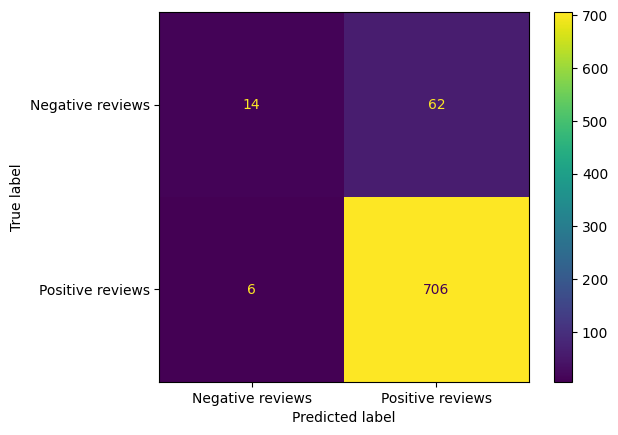

In [21]:
# Display a confusion matrix
matrix = confusion_matrix(y_test, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Negative reviews', 'Positive reviews'])

display.plot()
plt.show()

b) Metrics report

In [22]:
print(classification_report(y_test, predictions, target_names=['Negative reviews', 'Positive reviews']))

                  precision    recall  f1-score   support

Negative reviews       0.70      0.18      0.29        76
Positive reviews       0.92      0.99      0.95       712

        accuracy                           0.91       788
       macro avg       0.81      0.59      0.62       788
    weighted avg       0.90      0.91      0.89       788


1. What can we say about the reliability of the mode's prediction?

After analyzing the confusion matrix and the metrics, there is a big difference on the model's performance depending on the target to predict, which affects considerable its overall reliability. The model is fairly accurate when predicting positive reviews. However, due to the lack of negative samples, the model performs poorly when predicting a negative review. This model could definitely be useful in certain cases such as a filtering review comments in order to have a quick first impression of the product. But, since the model is pretty biased towards positive opinions it would be unfair to make important decisions on a product by just using the model itself.

2. What similarities and differences share the approach, development and resolutions of this case using Naïve Bayes compared to the two cases discussed in class (Spam analysis practice, in one hand, and identifying an anonymous sender of a letter, on the other hand)?

- Differences:
  - Data source: all three exercises have different method to obtain the data to analyze. The 'Anonymous sender' exercise had plain text file that just consisted on the messages with no other information. The 'Spam filter' exercise had a plain text file formatted as a TSV to separate the text to analyze and the target to predict. Finally, the data from the 'Amazon reviews' exercise came from a structured CSV file with not just the text, but also other features. Due to this difference of sources, the methods of reading the data and doing an early preprocessing were different according to the exercise needs.
  - Classification: another difference between these problems is that both the 'Amazon reviews' and the 'Spam filter' are binary classification problems and the anonymous sender is a multiclass identification problem .
  - Target: the last difference between these problems is that in the Amazon reviews there was no explicit target, and in order to obtain a target that could fit the problem description, it was needed to calculate it from another column. This was not an issue on the other problems because the target to predict was given, even thought both these cases had to encode the target into numerical values since the Naive Bayes algorithm works better this way.
- Similarities:
  - Text analysis: all the exercises have source data that includes text written by human beings. Before using this data, the text must be preprocessed to make sure the future model is not working with noise, stopwords or other nuisances.
  - Extract features: In order to generate features that a model can use, the text must be processed into numerical values. All three problems use the Bag of words (BoW) model in order to transform the text into the vectorized features needed for the model.
  - Methodology: in order to generate predictions, the exercises used Naive Bayes analytical model. This model has some key features that makes it really useful for all the exercises:
     - Can be used for both binary and multi-class problems.
     - Good performance with a limited amount of training data.
     - Predicts better than other models when we focus on features which are independent between them. Yields good results on problems like the ones on the three exercises, as they can be classified such as sentiment analysis problems.